<a href="https://colab.research.google.com/github/bingsen-wang/Electric-Machines/blob/main/ElectricMachines_VSRStepper_3phase3stack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>SRM Stepper Motor Three-Phase Three-Stack</h1></b>

Dr. Bingsen Wang

8/10/2024
</center>

#Python Code
The Python code illustrates the 3-phase 3-stack SRM stepping motor.

0
0
50
0


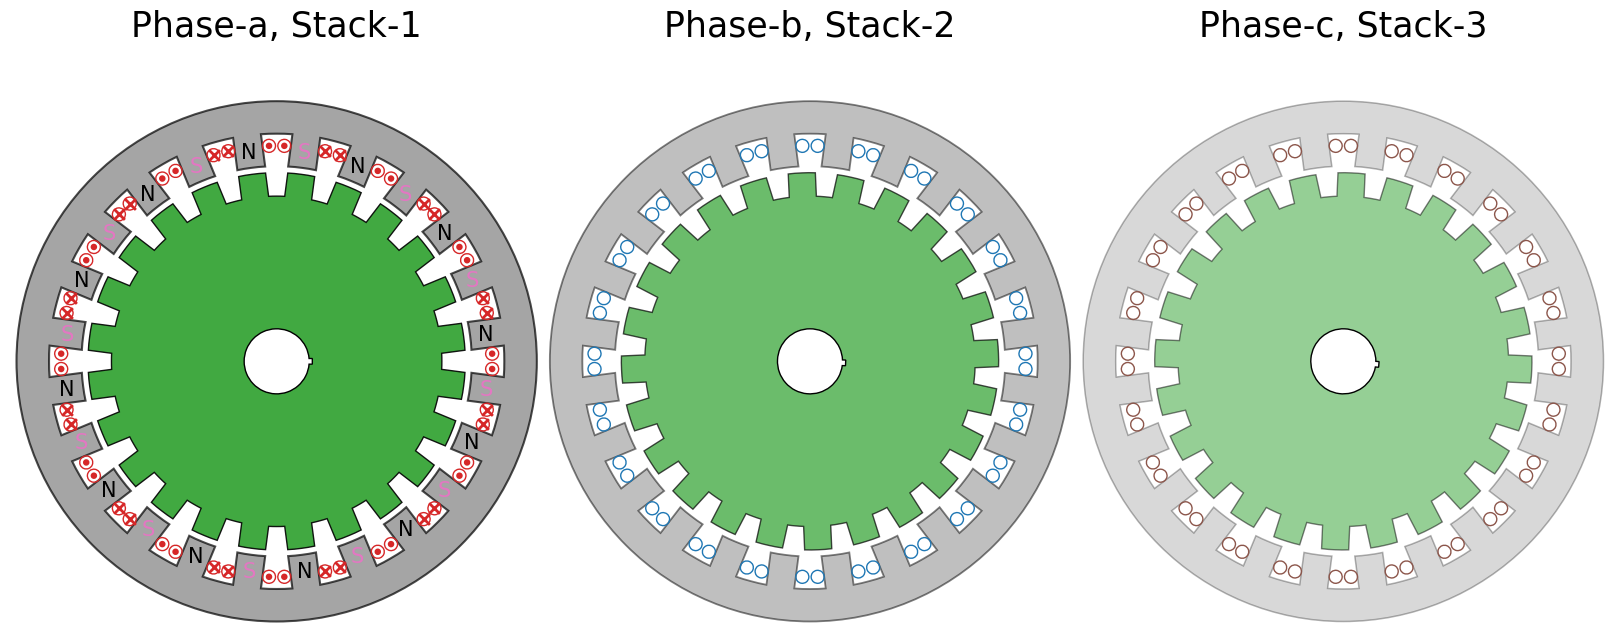

In [16]:
from os import linesep
import numpy as np
from numpy import linspace,cos,sin,pi,exp,angle,array,sqrt,arcsin,arccos,conj
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib.path import Path
from matplotlib.patches import PathPatch,Arc,Circle
from matplotlib import animation,transforms,colors
plt.rcParams.update({"font.family" : "sans serif","mathtext.fontset" : "cm"})

def axis_reset(ax): #clear axis for redrawing
  xy=ax.axis(); ax.cla(); ax.axis('off'); ax.set(xlim=xy[:2],ylim=xy[-2:])
  return
def re_im(c):
  return list(zip(c.real,c.imag))
def r2d(rad):
  return rad*180/pi
def d2r(deg):
  return deg*pi/180

def draw_rotor(ax,ro,ri,ns,fc='w',ec='k',lw=1,alpha=1,theta=0,theta_key=0): #straight teeth, round slot bottom
  """ro: outer radius;  ri: inner radius; ns: number of slots
  nsp: number of slots to plot"""
  tts = 2*pi/ns #tooth spacing in rad
  tso,ds = tts*.45, (ro-ri)*.15 #slot span at ro in rad, slot depth
  tsp,tsi = tso,tts-2*arcsin(ro*sin(.5*(tts-tso))/(ro-ds)) #slot opening, slot bottom angle span
  dt = 2*ro*sin(.5*(tts-tso)) #tooth thickness
  v,c=[],[]
  for k in range(ns):
    aci = Path.arc(r2d(tts*k-.5*tsi),r2d(tts*k+.5*tsi)) #inner arc
    aco = Path.arc(r2d(tts*k+.5*tsp),r2d(tts*(k+1)-.5*tsp)) #outer arc
    v += list(aci.vertices*(ro-ds)) + list(aco.vertices*ro)
    c += [Path.LINETO]+list(aci.codes[1:]) + [Path.LINETO] + list(aco.codes[1:])
  tr = transforms.Affine2D().rotate(theta)+ax.transData
  p = Path(v+[[0,0]],[Path.MOVETO]+c[1:]+[Path.CLOSEPOLY]) #rotor ourter shape
  ax.add_patch(PathPatch(p,ec=ec,fc=fc,alpha=alpha,lw=lw,transform=tr))

  tr = transforms.Affine2D().rotate(theta+theta_key)+ax.transData
  xy_key = array([exp(-1j*d2r(5))*ri+ri*.1,exp(1j*d2r(5))*ri+ri*.1]) # +/- 5 degrees for keyway
  p=Path(list(Path.arc(5,355).vertices*ri) + re_im(xy_key)+[[0,0]],
         list(Path.arc(5,355).codes)+[Path.LINETO]*2+[Path.CLOSEPOLY])
  ax.add_patch(PathPatch(p,ec=ec,fc='w',lw=lw,transform=tr)) #rotor inner
  return

def draw_stator(ax,ro,ri,ns,clst,fc='w',ec='k',lw=1,alpha=1,theta=0):
  ax.add_patch(mp.Circle((0,0),ro,lw=lw,fc=fc,ec=ec,alpha=alpha))
  tts = 2*pi/ns #tooth spacing in rad
  tsi,ds  = tts*.45, (ro-ri)*.5 #slot span at ri in rad, slot depth
  tsp,tso = tsi,tts-2*arcsin(ri*sin(.5*(tts-tsi))/(ri+ds)) #slot opening, slot bottom angle span
  dt = 2*ri*sin(.5*(tts-tsi)) #tooth thickness
  v,c=[],[] #vertices and codes
  #stator shape
  for k in range(ns):
    aco = Path.arc(r2d(tts*k-.5*tso),r2d(tts*k+.5*tso)) #outter arc
    aci = Path.arc(r2d(tts*k+.5*tsp),r2d(tts*(k+1)-.5*tsp)) #inner arc
    v += list(aco.vertices*(ri+ds)) + list(aci.vertices*ri)
    c += [Path.LINETO] + list(aco.codes[1:])+[Path.LINETO]+list(aci.codes[1:])
  tr = transforms.Affine2D().rotate(theta)+ax.transData
  p = Path(v+[[0,0]],[Path.MOVETO]+c[1:]+[Path.CLOSEPOLY])
  ax.add_patch(PathPatch(p,ec=colors.to_rgba(ec,alpha),fc='w',lw=lw,transform=tr))
  return
def draw_stator_conductors(ax,ro,ri,ns,clst,fc='w',ec='k',lw=1,alpha=1,theta=0,iabc=[0,0,1],phase=0):
  tts = 2*pi/ns #tooth spacing in rad
  tsi,ds  = tts*.45, (ro-ri)*.5 #slot span at ri in rad, slot depth
  dt = 2*ri*sin(.5*(tts-tsi)) #tooth thickness
  #conductors and polarities
  for k in range(ns):
    tr = transforms.Affine2D().rotate(theta+(k+.5)*tts)+ax.transData
    for kk in range(2):
      ax.add_patch(mp.Circle((ri+ds*.6,dt*.5+.2*ds-(dt+.4*ds)*kk),.2*ds,lw=1,fc='none',ec=clst[phase],transform=tr))
      if phase==np.nonzero(iabc)[0][0] and k%2==0:
        tr1 = transforms.Affine2D().rotate(theta+(k+.5-kk)*tts)+ax.transData
        ax.add_patch(mp.Circle((ri+ds*.6,-.5*dt-.2*ds+(dt+.4*ds)*kk),.1*ds,lw=lw,ec='none',fc=clst[phase],transform=tr1))
        tr1 = transforms.Affine2D().rotate(theta+(k-.5-kk)*tts)+ax.transData
        ax.scatter(ri+ds*.6,-.5*dt-.2*ds+(dt+.4*ds)*kk,s=60,marker='x',c=clst[phase],lw=2,transform=tr1)
        tr1 = transforms.Affine2D().rotate((k+.5-kk)*tts)+ax.transData
        ax.text(ri+ds*.5,0,['N','S'][kk%2],size=15,transform=tr1,
            color=[clst[-2],clst[4]][kk%2],va='center',ha='center')
  return

#parameters
Nfps = 72 #number of frames
Nst,Nrt = 24,24 #number of stator teeth, rotor teeth
rso,rro = 4,2.9 #stator outer radius, rotor outer radius
rsi,rri = 3,.5 #stator inner radius, rotor inner radius
f=1
t=linspace(0,1/f*(Nfps-1)/Nfps,Nfps) #time
i_ser = [[1,0,0], [0,1,0], [0,0,1]]

xylim = [[-4.1,4.1] for _ in range(2)]
clst=['tab:red','tab:blue','tab:brown','tab:orange','tab:pink','tab:olive','tab:grey','tab:green','k','w'] #colors light bg
fig = plt.figure(figsize=(16,9))
axs=[]
for k in range(6):
  axs.append(fig.add_axes((k%3/3,5.5/27,1/3,16/27),xlim=xylim[0],ylim=xylim[1],fc='none'))

for k in range(3):
  axs[k].axis('off')
  draw_stator(axs[k],rso,rsi,Nst,clst,fc=clst[-4],alpha=.7-k*.2,lw=1.5-k*.2)
  axs[k].text(0,5,'Phase-'+['a','b','c'][k]+', Stack-'+['1','2','3'][k],size=25,ha='center')
# animation function. This is called sequentially
def animate(i):
  # i=35
  if i%50==0: print(i)
  for k in range(3):
    axis_reset(axs[k+3]) #clear axis
    draw_stator_conductors(axs[k+3],rso,rsi,Nst,clst,fc=clst[-4],alpha=.7,lw=1.5-k*.2,iabc=i_ser[i%3],phase=k)
    draw_rotor(axs[k+3],rro,rri,Nrt,fc=clst[-3],alpha=.9-k*.2,lw=1,theta=2*pi*f*t[i]-2*pi/Nrt/3*k,theta_key=pi/Nrt/3*k)
  return
anim = animation.FuncAnimation(fig, animate, frames=Nfps)
anim.save("ElectricMachine_SRMStepper_3ph3stack.mp4", writer=animation.FFMpegWriter(fps=2),dpi = 200)